In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6l75stbk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6l75stbk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for patchify from https://files.pythonhosted.org/packages/00/ce/d76647d95aad98d5532b5d25801dedda788c6b5d4c7457d30ae3612132af/patchify-0.2.3-py3-none-any.whl.metadata


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
#from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import cv2
from datasets import Dataset
from PIL import Image
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import warnings
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Exposition of the classes of the dataset. Every item that appears in the dataset falls under a certain category.

In [3]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [4]:
num_classes = len(id_map.keys())
print(num_classes)

31


Load the train set.

In [5]:
train_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/"
valid_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/"

def get_images_masks(path):
    names=os.listdir(path)
    img_g,img_m=[],[]
    for name in tqdm(names):
        img=cv2.imread(path+name)
        #img=cv2.normalize(img,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=img[:,:,::-1]
        img_g.append(img[:,:256])
        img_m.append(img[:,256:])
        del img
    del names
    return img_g,img_m
        
X_train,Y_train=get_images_masks(train_folder)
X_val,Y_val=get_images_masks(valid_folder)

#train_len=len(train_imgs)
#valid_len=len(valid_imgs)
#print(f'Train Images:{train_len}\nValid Images:{valid_len}')

100%|██████████| 500/500 [00:04<00:00, 111.95it/s]


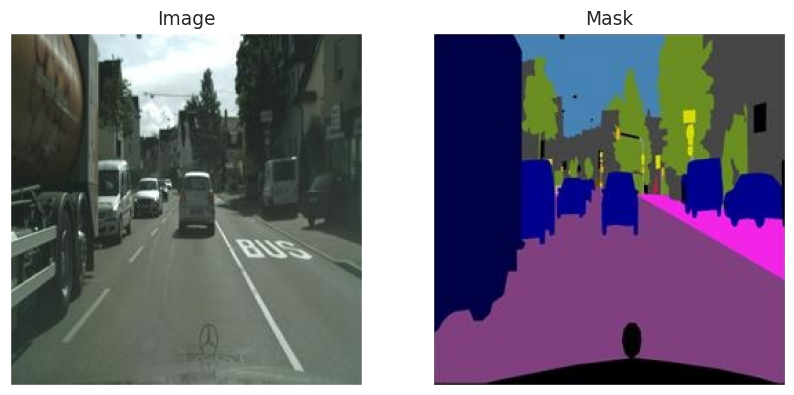

In [6]:
img_num = random.randint(0, 256)
example_image = X_train[img_num]
example_mask = Y_train[img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(example_image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

**Setup SAM's Automatic Mask Generator**

In [7]:
from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

In [8]:
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l" #
device = "cuda" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

In [9]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh = 0.86,
    stability_score_thresh = 0.92,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

**Example**

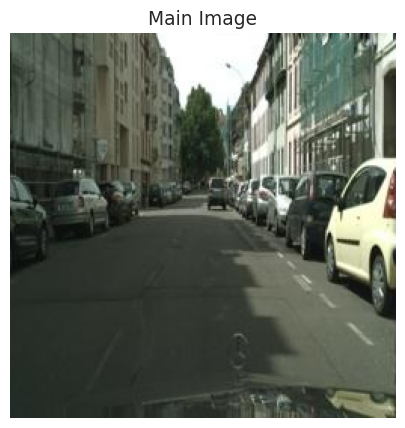

In [10]:
# Load the main image
main_image = X_train[4]

# Create a new figure for displaying the main image
plt.figure(figsize=(10, 5))
plt.imshow(main_image)
plt.axis('off')
plt.title('Main Image')

# Save the figures
plt.savefig('main_image.png', dpi=300)

# Show the plots
plt.show()

In [11]:
masks = mask_generator.generate(main_image)
print(len(masks))
print(masks[0].keys())

73
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [12]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

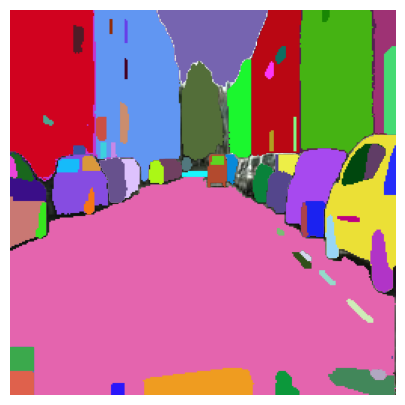

In [13]:
plt.figure(figsize=(10,5))
plt.imshow(main_image)
show_anns(masks)
plt.axis('off')
plt.show() 

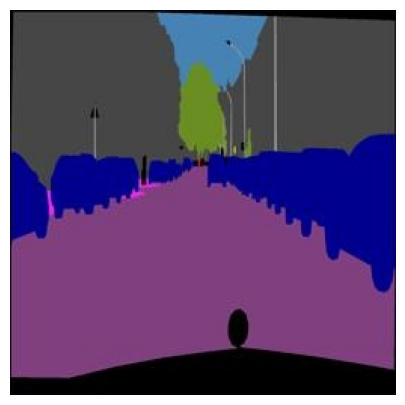

(256, 256, 3)


In [14]:
main_image_mask = Y_train[4]
plt.figure(figsize=(10,5))
plt.imshow(main_image_mask)
plt.axis('off')
plt.show() 
print(Y_train[0].shape)

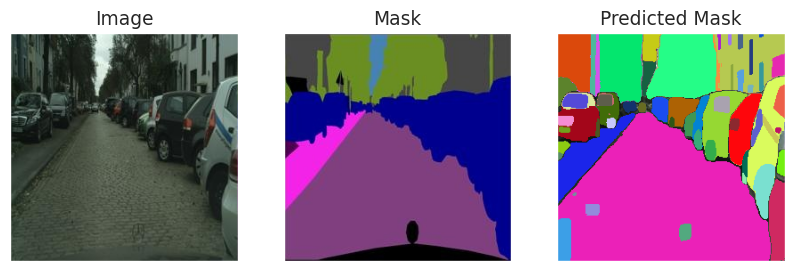

In [38]:
import random
img_num = random.randint(0, len(X_train))
example_image = X_train[img_num]
example_mask = Y_train[img_num]
masks = mask_generator.generate(example_image)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

axes[2].imshow(example_image, cmap='gray')  # Assuming the second image is grayscale
show_anns(masks)
axes[2].set_title("Predicted Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [22]:
# Ground truth mask
gt_mask = main_image_mask.astype(bool)  # Example ground truth mask

# Predicted mask
predicted_mask = masks[0]['segmentation']  # Example predicted mask

# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask[:,:,0], main_image[:,:,0])
union = np.logical_or(gt_mask[:,:,0], main_image[:,:,0])
iou = np.sum(intersection) / np.sum(union)

# Print the IoU score
print(f"Intersection over Union (IoU): {iou:.4f}")

Intersection over Union (IoU): 0.9336


**Inference on the whole dataset**

In [ ]:
iou_list = []
for i in tqdm(range(len(X_train))):
    main_image = X_train[i]
    main_image_mask = Y_train[i]
    masks = mask_generator.generate(main_image)
    gt_mask = main_image_mask.astype(bool)
    predicted_mask = masks[0]['segmentation']  
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(gt_mask[:,:,0], main_image[:,:,0])
    union = np.logical_or(gt_mask[:,:,0], main_image[:,:,0])
    iou = np.sum(intersection) / np.sum(union)
    iou_list.append(iou)

In [ ]:
np.mean(iou_list)

In [24]:
iou_list = []
for i in tqdm(range(len(X_val))):
    main_image = X_val[i]
    main_image_mask = Y_val[i]
    masks = mask_generator.generate(main_image)
    gt_mask = main_image_mask.astype(bool)
    predicted_mask = main_image.astype(bool)
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(gt_mask, predicted_mask)
    union = np.logical_or(gt_mask, predicted_mask)
    iou = np.sum(intersection) / np.sum(union)
    iou_list.append(iou)

100%|██████████| 500/500 [44:18<00:00,  5.32s/it]


In [26]:
np.mean(iou_list)

0.919168205233922

**CLIPSeg**

In [1]:
!pip install -q transformers

In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

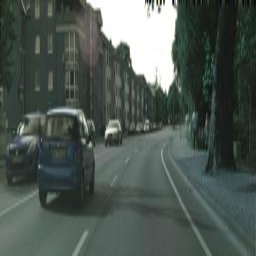

In [3]:
from PIL import Image
import requests

#url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/kaggle/input/cityscapes/train/img/train1009.png')
image = image.resize((256,256))
image

In [4]:
image.size

(256, 256)

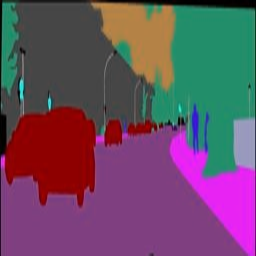

In [92]:
mask = Image.open('/kaggle/input/cityscapes/train/label/train1009.png')
mask = mask.resize((256,256))
mask

In [5]:
import torch
prompts = ["building", "car", "road", "tree","people"]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

Example of a Predicted Mask


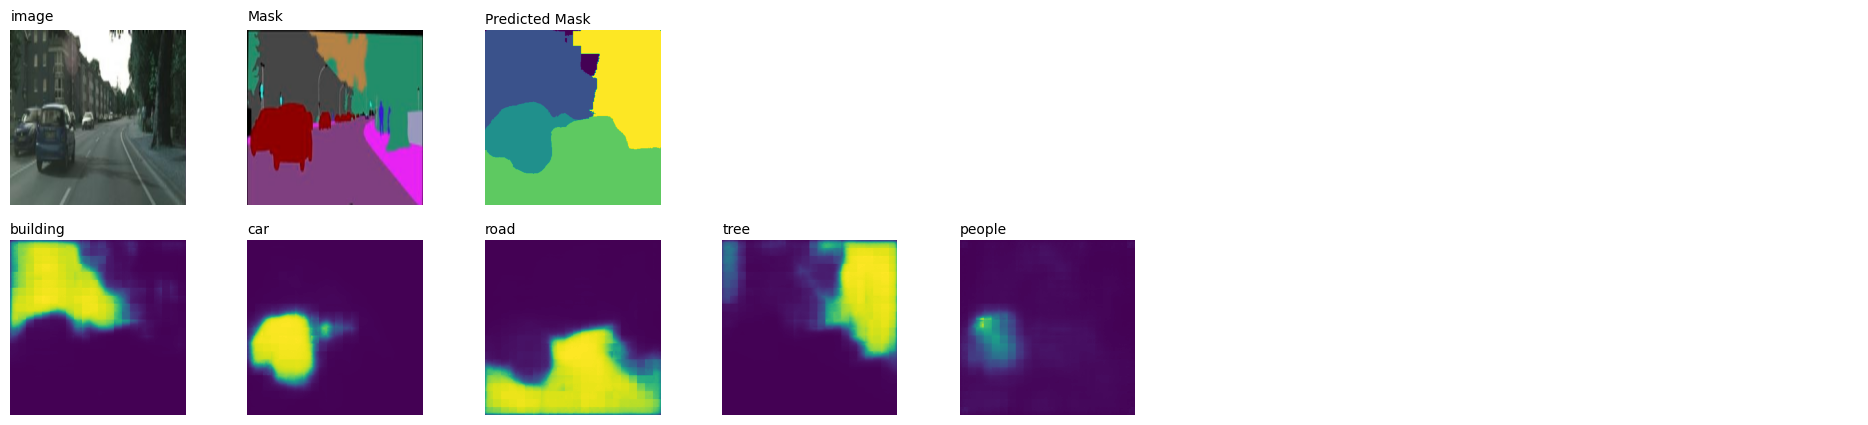

In [94]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(2, len(prompts) + 3, figsize=(3*(len(prompts) + 3), 5))
[a.axis('off') for a in ax.flatten()]
ax[0][0].imshow(image)
ax[0][0].text(0,-15,"image")
[ax[1][i].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[1][i].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

threshold = 0.1
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
[ax[0][2].imshow(inds)];
[ax[0][2].text(0, -15, "Predicted Mask")];

[ax[0][1].imshow(mask)];
[ax[0][1].text(0, -15, "Mask")];

Turning each mask to grayscale

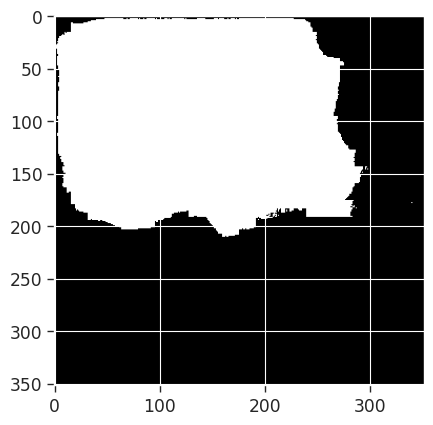

In [49]:
import matplotlib.pyplot as plt
import numpy as np
# apply sigmoid
medsam_seg_prob = torch.sigmoid(preds[0][0].squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.55).astype(np.uint8)
plt.imshow(medsam_seg, cmap='gray')

Combining the masks as one

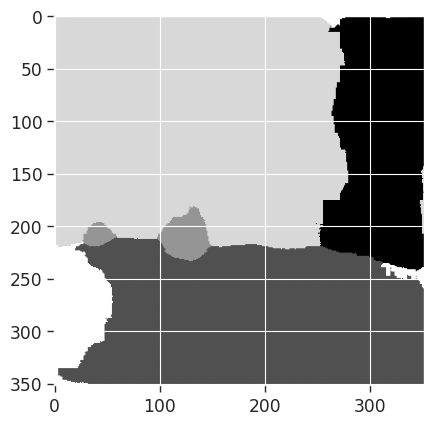

In [45]:
threshold = 0.1
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
plt.imshow(inds)

In [20]:
mask = Image.open('/kaggle/input/cityscapes/train/label/train1.png')
mask = mask.resize((352,352))
gt_mask = np.array(mask)[:,:,0].astype(bool)
predicted_mask = np.array(inds).astype(bool)
# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask, predicted_mask)
union = np.logical_or(gt_mask, predicted_mask)
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.9492268207644629


**Inference on the whole set**

In [23]:
from tqdm import tqdm
import glob
images = [img for img in glob.glob("/kaggle/input/cityscapes/val/img/*.png")]
images.sort()
masks = [mask for mask in glob.glob("/kaggle/input/cityscapes/val/label/*.png")]
masks.sort()
iou_list = []
for i in tqdm(range(len(images))):
  image = Image.open(images[i])
  inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  preds = outputs.logits.unsqueeze(1)
  threshold = 0.1

  flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

  # Initialize a dummy "unlabeled" mask with the threshold
  flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
  flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

  # Get the top mask index for each pixel
  inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
  mask = Image.open(masks[i])
  mask = mask.resize((352,352))
  gt_mask = np.array(mask)[:,:,0].astype(bool)
  predicted_mask = np.array(inds).astype(bool)
  # Calculate Intersection over Union (IoU)
  intersection = np.logical_and(gt_mask, predicted_mask)
  union = np.logical_or(gt_mask, predicted_mask)
  iou = np.sum(intersection) / np.sum(union)
  #print(iou)
  iou_list.append(iou)

100%|██████████| 500/500 [20:34<00:00,  2.47s/it]


In [25]:
np.mean(iou_list)

0.9623601161551073